In [205]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [206]:
!pip install ipdb

In [0]:
import numpy as np
import pandas as pd
import ipdb
import pprint
import sys
import matplotlib.pyplot as plt
import math
import operator
import csv
from copy import deepcopy
from tabulate import tabulate

eps = np.finfo(float).eps
from numpy import log2 as log

In [0]:
def standardize_data(X):
    return (X - X.mean())/X.std()

In [0]:
root_path = "/content/gdrive/My Drive/Semester_#2/CSE471_SM_in_AI/Assignments/9/2018201058_assignment9"

In [0]:
data = pd.read_csv(root_path + "/input_data/data.csv")
labels = data.iloc[:, -1]

In [0]:
# removing the output column
data_std = standardize_data(data.iloc[:, :-1])
train = data_std

In [0]:
def intercept_add(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [0]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def linear(x, c):
    return c * x
  
def stable_softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shift_x = x - np.array([np.max(x, axis=1)]).T
    exps = np.exp(shift_x)
    return exps / np.array([np.sum(exps, axis=1)]).T

In [0]:
# Derivative Functions
def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1. * (x > 0)

def tanh_derivative(x):
    return (1 - (x ** 2))

def linear_derivative(x, c):
    return np.full((x.shape[0], x.shape[1]), c)

In [0]:
def mse(X, Y):
    errors = X - Y
    square_errors = np.power(errors, 2)
    return errors, square_errors, (np.sum(square_errors) / (2 * len(X)))

In [0]:
def cross_entropy_get(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
#     predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions + 1e-9))/N
    return ce

In [0]:
class NeuralNetwork:
    def __init__(self, num_neurons_list, actn_func = "sigmoid", lr = 0.1, wts = None):
        # initialize HyperParameters
        self.num_neurons_list = deepcopy(num_neurons_list)
        self.num_layers = len(self.num_neurons_list)
        for i in range(self.num_layers-1):
            self.num_neurons_list[i] += 1

        self.num_hidden_layers = self.num_layers - 2
        self.activation_func = actn_func
        self.lr = lr

        self.cross_entropies = []

        if wts is None:
            self.weights = []
            self.d_weights = []

            for i in range(self.num_layers-1):
                bound = np.sqrt(1./(self.num_neurons_list[i]))
                self.weights.append(np.random.uniform(-bound, bound, (self.num_neurons_list[i], self.num_neurons_list[i+1])))
                self.d_weights.append(np.zeros((self.num_neurons_list[i], self.num_neurons_list[i+1])))
        else:
            for i in range(len(wts)):
                if (self.num_neurons_list[i] != wts[i].shape[0]) or (self.num_neurons_list[i + 1] != wts[i].shape[1]):
                    print ("Weights provided have invalid dimensions!!")
                    sys.exit(-1)

            self.weights = wts


    def forward_prop(self, X):
        self.L_out = []
        self.L_in = []

        X = intercept_add(X)
        self.L_in.append(X)
        self.L_out.append(X)
        prev_out = None

        for l in range(1, len(self.num_neurons_list)):
            prev_out = self.L_out[-1]
            curr_in = prev_out @ self.weights[l-1]
            self.L_in.append(curr_in)

            if l == (len(self.num_neurons_list)//2):
                curr_out = sigmoid(curr_in)
            else:
                if self.activation_func == "sigmoid":
                    curr_out = sigmoid(curr_in)
                elif self.activation_func == "relu":
                    curr_out = relu(curr_in)
                elif self.activation_func == "tanh":
                    curr_out = tanh(curr_in)
                elif self.activation_func == "linear":
                    curr_out = linear(curr_in, 1)
                else:
                    print ("Invalid Activation Function!!")
                    sys.exit(-1)
            self.L_out.append(curr_out)


    def bottleneck_output_get(self, X):
        X = intercept_add(X)
        curr_out = X
        prev_out = None

        for l in range(1, (len(self.num_neurons_list) // 2) + 1):
            prev_out = curr_out
            curr_in = prev_out @ self.weights[l-1]

            if l == (len(self.num_neurons_list)//2):
                curr_out = sigmoid(curr_in)
            else:
                if self.activation_func == "sigmoid":
                    curr_out = sigmoid(curr_in)
                elif self.activation_func == "relu":
                    curr_out = relu(curr_in)
                elif self.activation_func == "tanh":
                    curr_out = tanh(curr_in)
                elif self.activation_func == "linear":
                    curr_out = linear(curr_in, 1)
                else:
                    print ("Invalid Activation Function!!")
                    sys.exit(-1)

        return curr_out[:, 1:]


    def backward_prop(self, y):
        error = 2 * (y - self.L_out[-1])
        
        for i in reversed(range(self.num_layers-1)):
            if i == ((self.num_layers // 2) - 1) or self.activation_func == "sigmoid":
                self.d_weights[i] = np.dot(self.L_out[i].T, (error * sigmoid_derivative(self.L_in[i+1])))
            elif self.activation_func == "relu":
                self.d_weights[i] = np.dot(self.L_out[i].T, (error * relu_derivative(self.L_in[i+1])))
            elif self.activation_func == "tanh":
                self.d_weights[i] = np.dot(self.L_out[i].T, (error * tanh_derivative(self.L_in[i+1])))
            elif self.activation_func == "linear":
                self.d_weights[i] = np.dot(self.L_out[i].T, (error * linear_derivative(self.L_in[i+1], 1)))
            else:
                print ("Invalid Activation Function!!")
                sys.exit(-1)

            error = error @ self.weights[i].T

        for i in range(self.num_layers-1):
            self.weights[i] += (self.lr * self.d_weights[i])


    def fit(self, train_df, batch_size, num_epochs):
        n = len(train_df.index)
        train_x = train_df.iloc[:, :].values
        for n_epoch in range(num_epochs):
            epoch_cost = 0.0
            s, e = 0, batch_size
            num_mini_bactches = 0
            while (s < n):
                num_mini_bactches += 1

                e = min(n, s + batch_size)

                self.forward_prop(train_x[s:e, :]/100)
                self.backward_prop(train_x[s:e, :]/100)

                minibatch_cost = mse(self.L_out[-1], train_x[s:e, :]/100)
                epoch_cost += minibatch_cost[2]

                s = e

            epoch_cost = epoch_cost / num_mini_bactches
            self.cross_entropies.append(epoch_cost)

            if n_epoch % 50 == 0:
                print ("No. of Epochs:", n_epoch, "MSE:", epoch_cost)


    def predictions_get(self, data_df):
        self.forward_prop(data_df.values)
        return self.L_out[-1].argmax(axis=1)

    def accuracy_get(self, validate_df):
        predictions = self.predictions_get(validate_df.iloc[:, :-1])
        accuracy = 100 * np.mean(predictions == validate_df["label"])
        return round(accuracy, 2)

In [0]:
# def error_graph_plot(errors, num_epochs):
#     fig, ax = plt.subplots(figsize=(12,6))
#     ax.plot(list(range(num_epochs)), errors, color="red", lw=1, ls='-');
#     plt.xlabel("Number of Epochs")
#     plt.ylabel("Cross Entropy")
#     plt.title("Error vs Number of Epochs")
#     plt.show()

## Question 1

### Part-1-a: Sparce Autoencoder with Linear activation functions

In [238]:
sparce_autoencoder_linear = NeuralNetwork([29, 14, 29], "linear", 0.0001)
sparce_autoencoder_linear.fit(train, 500, 1000)
reduced_X1 = sparce_autoencoder_linear.bottleneck_output_get(train)

No. of Epochs: 0 MSE: 0.03644273280815881
No. of Epochs: 50 MSE: 0.0014349761836410324
No. of Epochs: 100 MSE: 0.001432907284684157
No. of Epochs: 150 MSE: 0.001430803231376237
No. of Epochs: 200 MSE: 0.0014286581468778733
No. of Epochs: 250 MSE: 0.001426465990696359
No. of Epochs: 300 MSE: 0.0014242205351848623
No. of Epochs: 350 MSE: 0.0014219153437446694
No. of Epochs: 400 MSE: 0.0014195437510213073
No. of Epochs: 450 MSE: 0.0014170988454550429
No. of Epochs: 500 MSE: 0.0014145734546191539
No. of Epochs: 550 MSE: 0.0014119601338549088
No. of Epochs: 600 MSE: 0.0014092511587893016
No. of Epochs: 650 MSE: 0.0014064385223989454
No. of Epochs: 700 MSE: 0.0014035139373596317
No. of Epochs: 750 MSE: 0.0014004688444939684
No. of Epochs: 800 MSE: 0.001397294428197151
No. of Epochs: 850 MSE: 0.0013939816397809512
No. of Epochs: 900 MSE: 0.0013905212297257504
No. of Epochs: 950 MSE: 0.0013869037898669126


In [239]:
reduced_X1.shape

(24998, 14)

### Part-1-b: Sparce Autoencoder with Non-Linear activation functions

In [240]:
sparce_autoencoder_relu = NeuralNetwork([29, 14, 29], "relu", 0.00001)
sparce_autoencoder_relu.fit(train, 500, 500)
reduced_X2 = sparce_autoencoder_relu.bottleneck_output_get(train)

No. of Epochs: 0 MSE: 0.17754230787648861
No. of Epochs: 50 MSE: 0.0014394504758869042
No. of Epochs: 100 MSE: 0.0014394163794519666
No. of Epochs: 150 MSE: 0.0014393836717102096
No. of Epochs: 200 MSE: 0.001439351535133051
No. of Epochs: 250 MSE: 0.0014393199392821552
No. of Epochs: 300 MSE: 0.001439288131669577
No. of Epochs: 350 MSE: 0.0014392566014086645
No. of Epochs: 400 MSE: 0.0014392252109798837
No. of Epochs: 450 MSE: 0.001439193926249963


In [241]:
reduced_X2.shape

(24998, 14)

### Part-1-c: Deep Autoencoder with Non-Linear activation functions

In [242]:
deep_autoencoder_sigmoid = NeuralNetwork([29, 20, 14, 20, 29], "sigmoid", 0.00000001)
deep_autoencoder_sigmoid.fit(train, 500, 1000)
reduced_X3 = deep_autoencoder_sigmoid.bottleneck_output_get(train)

No. of Epochs: 0 MSE: 3.8638041364771967
No. of Epochs: 50 MSE: 3.854304402840124
No. of Epochs: 100 MSE: 3.8447290334488087
No. of Epochs: 150 MSE: 3.8351992477520804
No. of Epochs: 200 MSE: 3.825823558989427
No. of Epochs: 250 MSE: 3.8166983033615485
No. of Epochs: 300 MSE: 3.807908374309201
No. of Epochs: 350 MSE: 3.799528062906577
No. of Epochs: 400 MSE: 3.7916218652587417
No. of Epochs: 450 MSE: 3.78424505125075
No. of Epochs: 500 MSE: 3.7774436759508596
No. of Epochs: 550 MSE: 3.7712535259093847
No. of Epochs: 600 MSE: 3.765697190842029
No. of Epochs: 650 MSE: 3.7607780141652354
No. of Epochs: 700 MSE: 3.7564691772440346
No. of Epochs: 750 MSE: 3.7526960298002137
No. of Epochs: 800 MSE: 3.7493113697983294
No. of Epochs: 850 MSE: 3.746070152342284
No. of Epochs: 900 MSE: 3.7426280439102353
No. of Epochs: 950 MSE: 3.7386188129830664


In [243]:
reduced_X3.shape

(24998, 14)

## Part-2: K-means

In [0]:
def KMeans(data, k, max_iterations):
    n = data.shape[0]
    c = data.shape[1]
    
    std = np.std(data, axis = 0)
    mean = np.mean(data, axis = 0)
    centers = np.random.randn(k,c)*std + mean

    centers_old = np.zeros(centers.shape)   # to store old centers
    centers_new = deepcopy(centers)         # Store new centers

    clusters = np.zeros(n)
    distances = np.zeros((n,k))
    error = np.linalg.norm(centers_new - centers_old)
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(data[:,0], data[:,1], s=7)
    ax.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='r', s=150)
    plt.show()

    # When, after an update, the estimate of that center stays the same, exit loop
    while max_iterations != 0 and error != 0:        
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1)

        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        centers_old = deepcopy(centers_new)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            centers_new[i] = np.mean(data[clusters == i], axis=0)

        error = np.linalg.norm(centers_new - centers_old)
        max_iterations -= 1

    print (max_iterations)
    fig, ax = plt.subplots(figsize=(14,7))
    colors = ['r', 'g', 'b', 'c', 'y']
    markers = ['+', '^', 'o', 'v', 's']
    for i in range(k):
        ax.scatter(data[clusters == i][:, 0], data[clusters == i][:, 1], s=7, marker=markers[i], c=colors[i])
        ax.scatter(centers_new[i,0], centers_new[i,1], marker='*', c='black', s=150)
    plt.show()

    return clusters, centers_new

### reduced_X1 (K-Means)

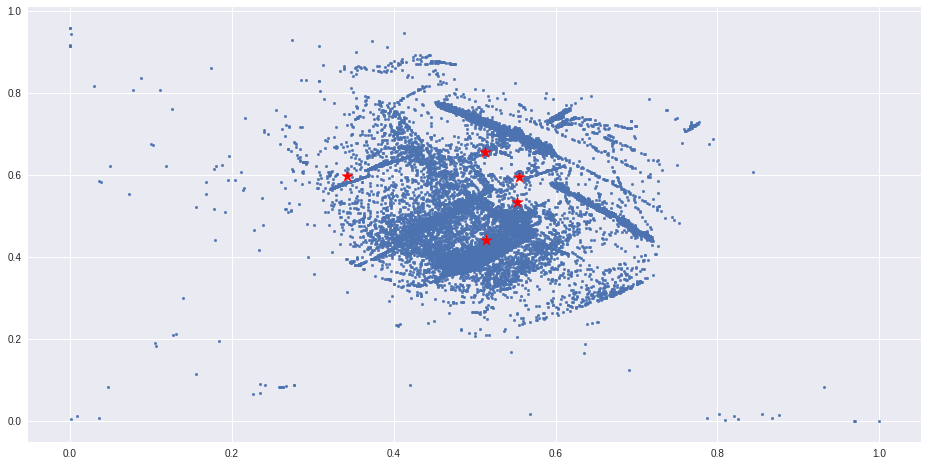

91


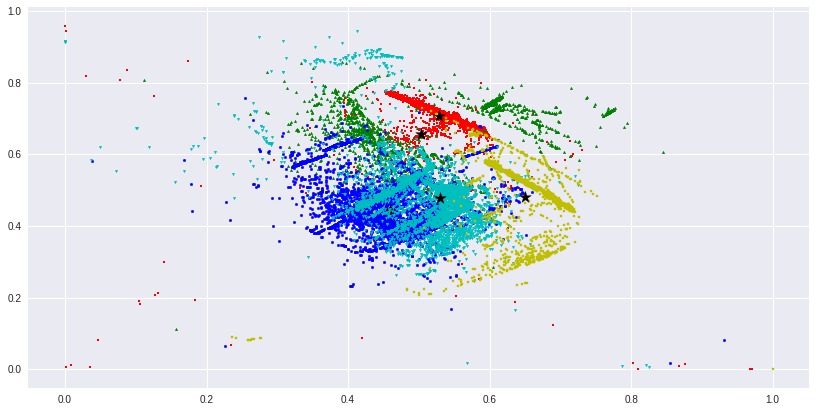

In [259]:
clusters, centers = KMeans(reduced_X1, 5, 100)

In [260]:
cluster_series = pd.Series(clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
df_confusion = pd.crosstab(label_series, cluster_series, margins=True)
df_confusion = df_confusion.iloc[:-1, :-1]
print(tabulate(df_confusion, headers='keys', tablefmt='psql'))

+-----------+------+-----+------+------+------+
| Classes   |    0 |   1 |    2 |    3 |    4 |
|-----------+------+-----+------+------+------|
| dos       | 6824 |  37 |   57 |  832 | 1364 |
| normal    |   90 | 672 | 5190 | 7003 |  409 |
| probe     |   26 | 923 |  855 |  162 |  347 |
| r2l       |    0 |   1 |  114 |   72 |   10 |
| u2r       |    0 |   0 |    4 |    6 |    0 |
+-----------+------+-----+------+------+------+


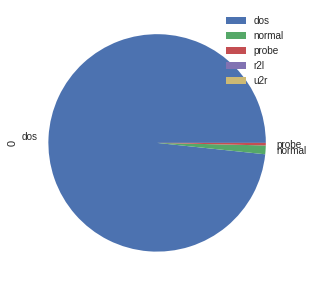

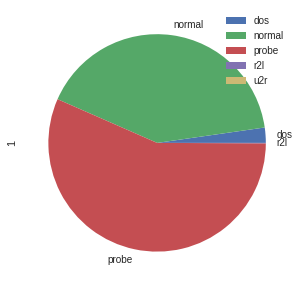

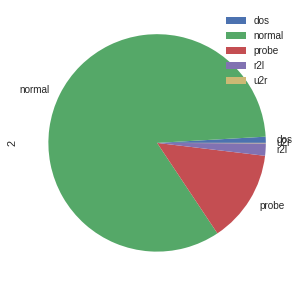

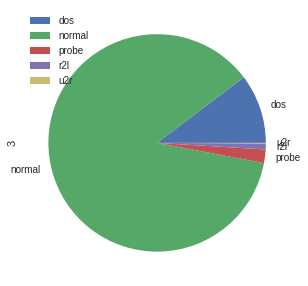

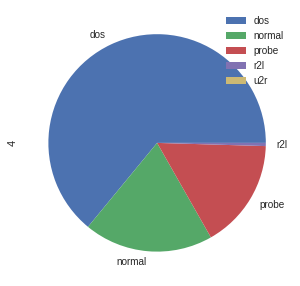

In [261]:
# Pie chart using Pandas
for i in range(0,5):
    plot = df_confusion.plot.pie(y= i, figsize=(5, 5))

In [0]:
def purity_get(confusion_df):
    max_vals = np.array([confusion_df.max()])
    purity = max_vals.sum()/data.shape[0]
    return purity

In [263]:
purity_X1_kmeans =  purity_get(df_confusion)
purity_X1_kmeans

0.8522281782542603

### reduced_X2 (K-Means)

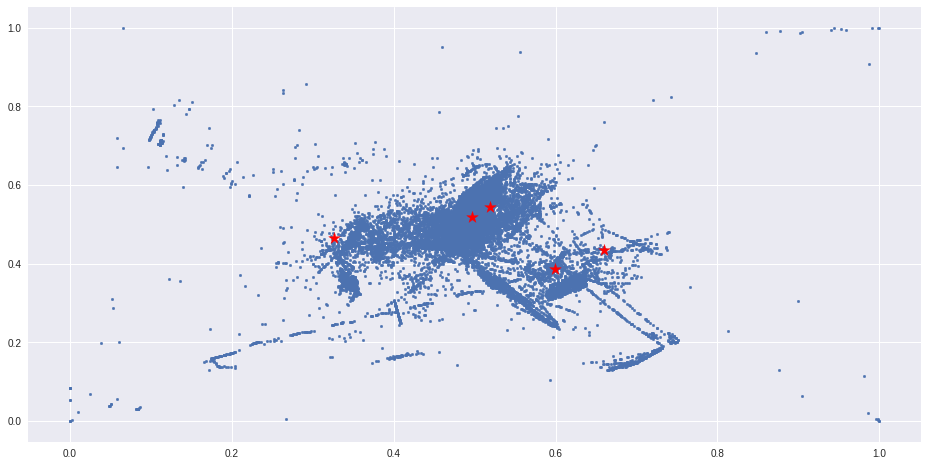

82


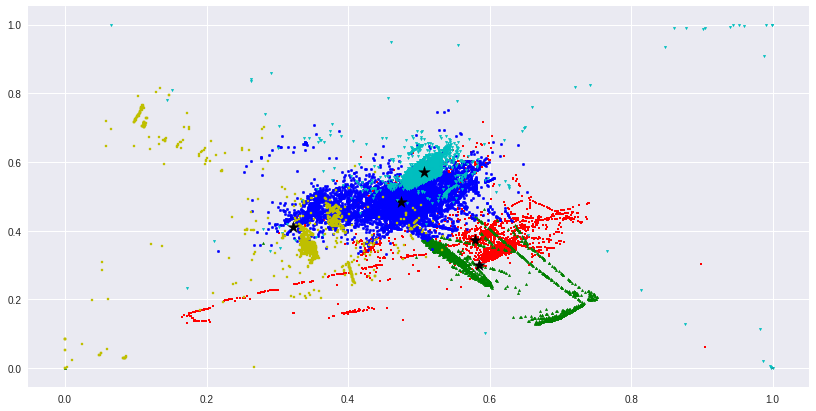

In [264]:
clusters, centers = KMeans(reduced_X2, 5, 100)

In [265]:
cluster_series = pd.Series(clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
df_confusion = pd.crosstab(label_series, cluster_series, margins=True)
df_confusion = df_confusion.iloc[:-1, :-1]
print(tabulate(df_confusion, headers='keys', tablefmt='psql'))

+-----------+------+------+-------+------+-----+
| Classes   |    0 |    1 |     2 |    3 |   4 |
|-----------+------+------+-------+------+-----|
| dos       | 1364 |  475 |   453 | 6814 |   8 |
| normal    |  754 | 1315 | 10839 |  186 | 270 |
| probe     | 1096 |    2 |   385 |   67 | 763 |
| r2l       |    0 |    0 |   113 |    5 |  79 |
| u2r       |    0 |    0 |    10 |    0 |   0 |
+-----------+------+------+-------+------+-----+


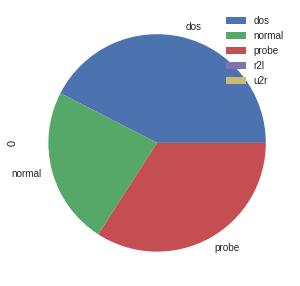

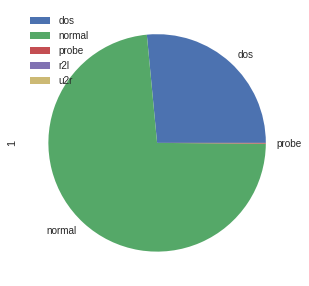

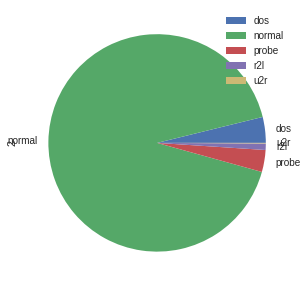

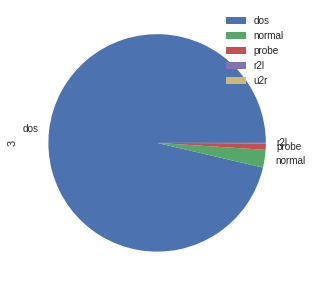

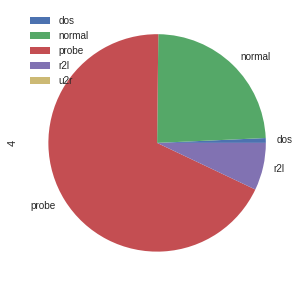

In [266]:
# Pie chart using Pandas
for i in range(0,5):
    plot = df_confusion.plot.pie(y= i, figsize=(5, 5))

In [267]:
purity_X2_kmeans =  purity_get(df_confusion)
purity_X2_kmeans

0.8438675094007521

### reduced_X3 (K-Means)

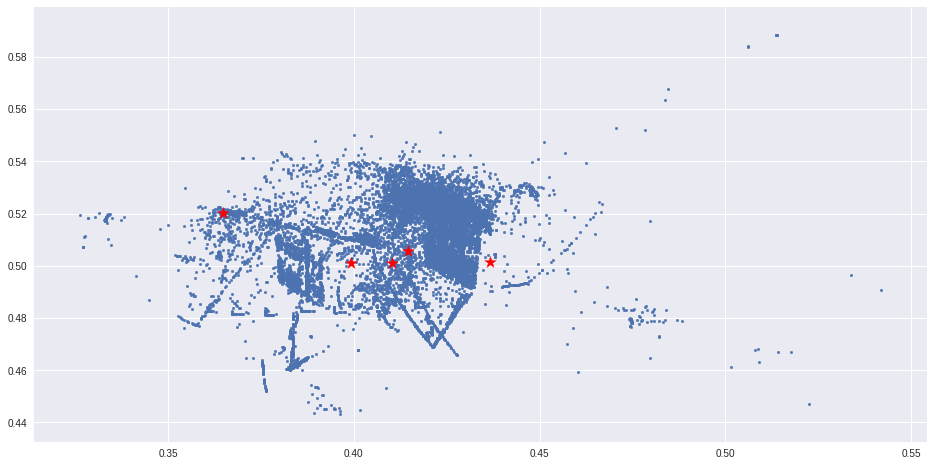

84


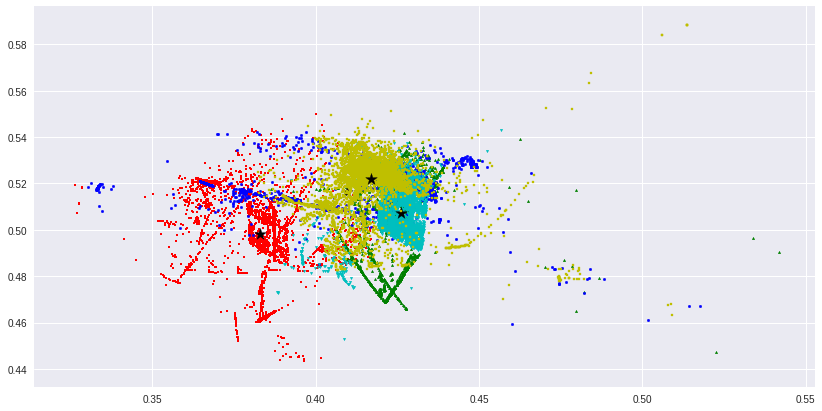

In [268]:
clusters, centers = KMeans(reduced_X3, 5, 100)

In [269]:
cluster_series = pd.Series(clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
df_confusion = pd.crosstab(label_series, cluster_series, margins=True)
df_confusion = df_confusion.iloc[:-1, :-1]
print(tabulate(df_confusion, headers='keys', tablefmt='psql'))

+-----------+------+------+-----+------+------+
| Classes   |    0 |    1 |   2 |    3 |    4 |
|-----------+------+------+-----+------+------|
| dos       | 1364 |  702 |  22 | 6817 |  209 |
| normal    |  625 | 4800 | 999 |   53 | 6887 |
| probe     |  924 |   44 | 820 |  115 |  410 |
| r2l       |    2 |    3 |  68 |    2 |  122 |
| u2r       |    0 |    3 |   1 |    0 |    6 |
+-----------+------+------+-----+------+------+


In [271]:
purity_X3_kmeans =  purity_get(df_confusion)
purity_X3_kmeans

0.8347467797423794

## Part-3: GMM

### Imports

In [0]:
from sklearn.mixture import GaussianMixture

### reduced_X1 (GMM)

In [275]:
gmm = GaussianMixture(n_components=5, random_state=3)
clf = gmm.fit(reduced_X1)
clf.weights_

array([0.16077449, 0.2237466 , 0.2467748 , 0.18039549, 0.18830862])

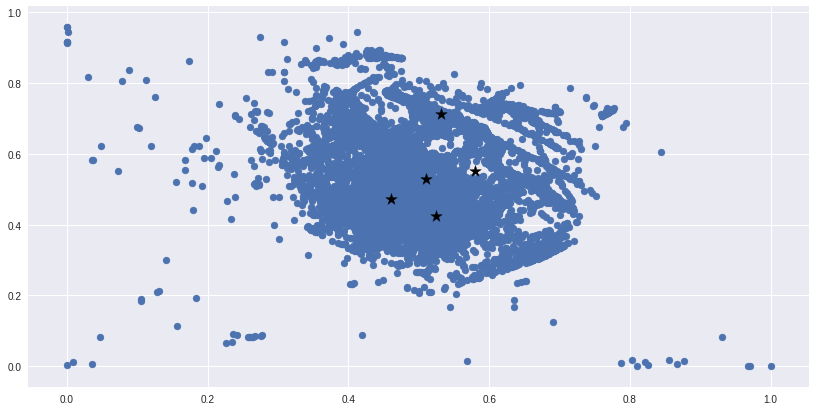

In [277]:
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(reduced_X1[:,0], reduced_X1[:,1])
for i in range(5):
    ax.scatter(gmm.means_[i,0], gmm.means_[i,1], marker='*', c='black', s=150)
plt.show()

In [278]:
pred_clusters = gmm.predict(reduced_X1)
pred_clusters

array([1, 0, 1, ..., 4, 3, 2])

In [279]:
cluster_series = pd.Series(pred_clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
gmm_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
gmm_confusion_df = gmm_confusion_df.iloc[:-1, :-1]
print(tabulate(gmm_confusion_df, headers='keys', tablefmt='psql'))

+-----------+------+------+------+------+------+
| Classes   |    0 |    1 |    2 |    3 |    4 |
|-----------+------+------+------+------+------|
| dos       | 1481 |    0 | 6169 |   97 | 1367 |
| normal    | 1234 | 5591 |    0 | 3432 | 3107 |
| probe     | 1308 |    0 |    0 |  886 |  119 |
| r2l       |    5 |    0 |    0 |   95 |   97 |
| u2r       |    0 |    0 |    0 |    3 |    7 |
+-----------+------+------+------+------+------+


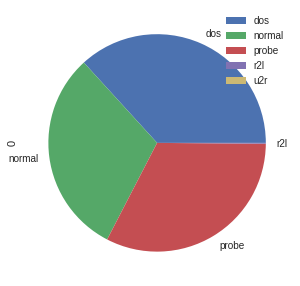

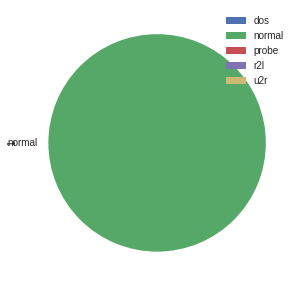

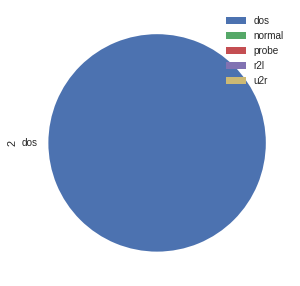

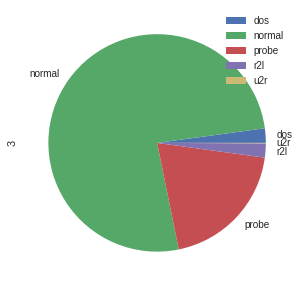

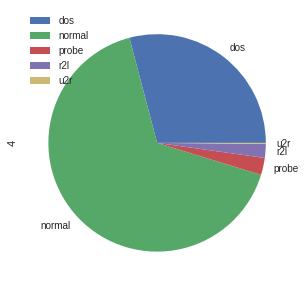

In [280]:
for i in range(0,5):
    plot = gmm_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [282]:
purity_X1_gmm =  purity_get(gmm_confusion_df)
purity_X1_gmm

0.7912633010640852

### reduced_X2 (GMM)

In [283]:
clf = gmm.fit(reduced_X2)
clf.weights_

array([0.09046292, 0.22689906, 0.24811879, 0.24765027, 0.18686895])

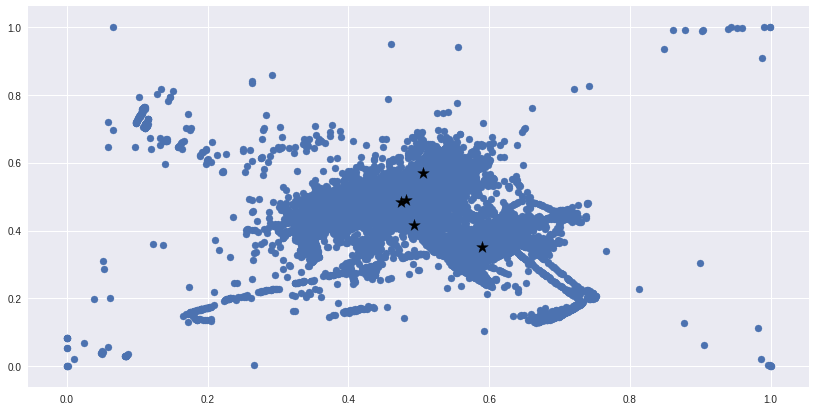

In [284]:
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(reduced_X2[:,0], reduced_X2[:,1])
for i in range(5):
    ax.scatter(gmm.means_[i,0], gmm.means_[i,1], marker='*', c='black', s=150)
plt.show()

In [285]:
pred_clusters = gmm.predict(reduced_X2)
pred_clusters

array([1, 0, 1, ..., 4, 3, 2])

In [286]:
cluster_series = pd.Series(pred_clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
gmm_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
gmm_confusion_df = gmm_confusion_df.iloc[:-1, :-1]
print(tabulate(gmm_confusion_df, headers='keys', tablefmt='psql'))

+-----------+------+------+------+------+------+
| Classes   |    0 |    1 |    2 |    3 |    4 |
|-----------+------+------+------+------+------|
| dos       | 1326 |    0 | 6202 |  606 |  980 |
| normal    |  111 | 5670 |    0 | 4656 | 2927 |
| probe     |  827 |    0 |    0 |  833 |  653 |
| r2l       |    0 |    0 |    0 |   93 |  104 |
| u2r       |    0 |    0 |    0 |    3 |    7 |
+-----------+------+------+------+------+------+


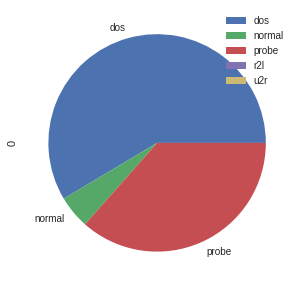

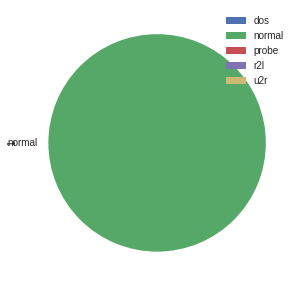

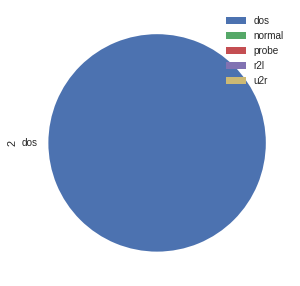

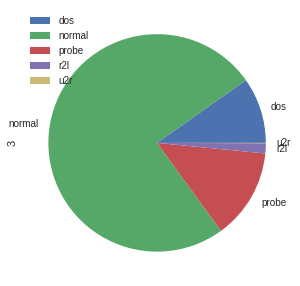

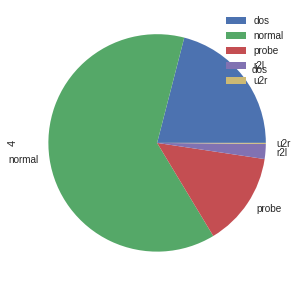

In [287]:
for i in range(0,5):
    plot = gmm_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [288]:
purity_X2_gmm =  purity_get(gmm_confusion_df)
purity_X2_gmm

0.8313065045203616

### reduced_X3 (GMM)

In [289]:
clf = gmm.fit(reduced_X3)
clf.weights_

array([0.1271908 , 0.25837269, 0.40216377, 0.14913699, 0.06313576])

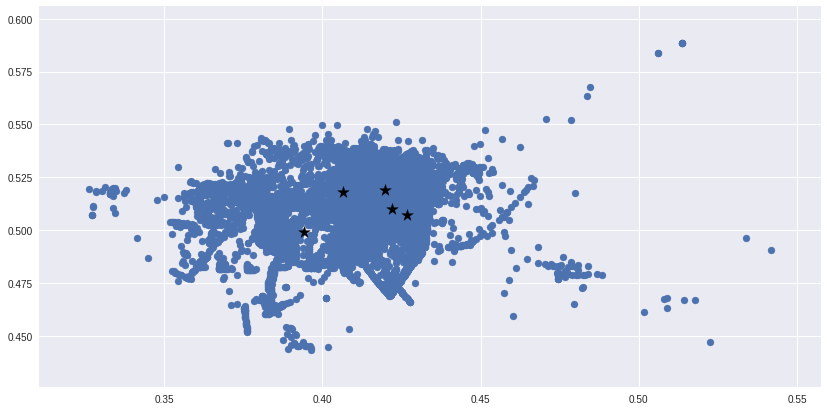

In [290]:
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(reduced_X3[:,0], reduced_X3[:,1])
for i in range(5):
    ax.scatter(gmm.means_[i,0], gmm.means_[i,1], marker='*', c='black', s=150)
# ax.axis('equal')
plt.show()

In [291]:
pred_clusters = gmm.predict(reduced_X3)
pred_clusters

array([2, 0, 2, ..., 4, 3, 1])

In [292]:
cluster_series = pd.Series(pred_clusters, name='Clusters')
label_series = pd.Series(labels, name='Classes')
gmm_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
gmm_confusion_df = gmm_confusion_df.iloc[:-1, :-1]
print(tabulate(gmm_confusion_df, headers='keys', tablefmt='psql'))

+-----------+------+------+------+------+-----+
| Classes   |    0 |    1 |    2 |    3 |   4 |
|-----------+------+------+------+------+-----|
| dos       | 1417 | 6459 |  645 |  211 | 382 |
| normal    |  743 |    0 | 9343 | 2460 | 818 |
| probe     | 1013 |    0 |   73 |  900 | 327 |
| r2l       |    2 |    0 |    4 |  146 |  45 |
| u2r       |    0 |    0 |    0 |    6 |   4 |
+-----------+------+------+------+------+-----+


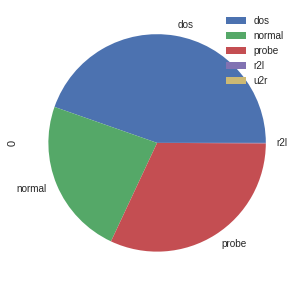

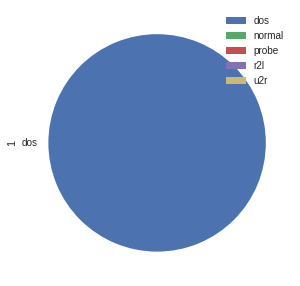

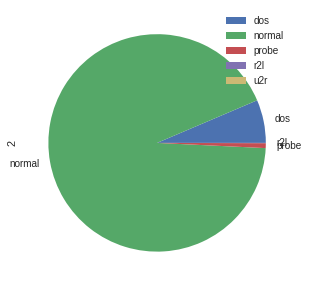

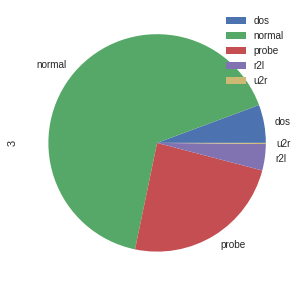

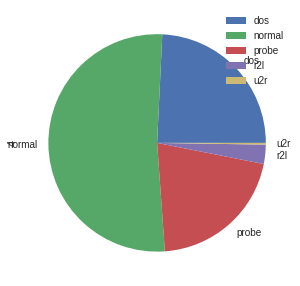

In [293]:
for i in range(0,5):
    plot = gmm_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [294]:
purity_X3_gmm =  purity_get(gmm_confusion_df)
purity_X3_gmm

0.8199455956476518

## Part-4: Hierarchical Clustering

In [0]:
from sklearn.cluster import AgglomerativeClustering

### reduced_X1

In [296]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(reduced_X1)

array([4, 2, 4, ..., 0, 1, 3])

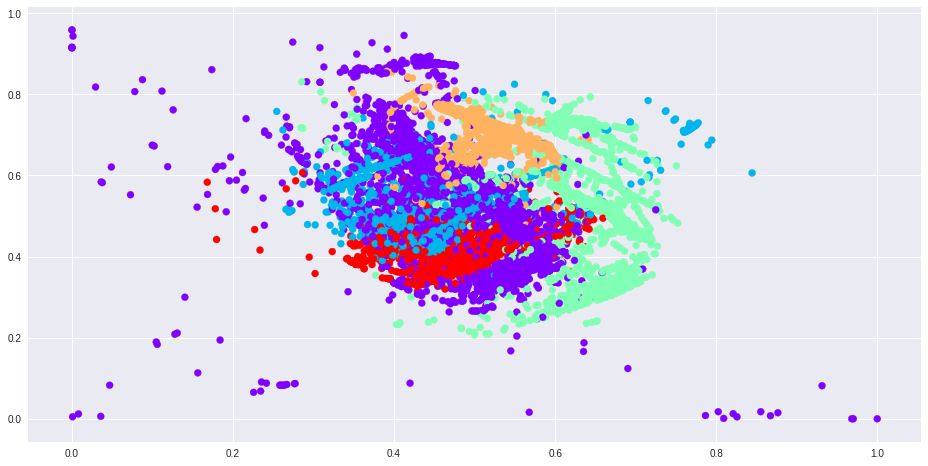

In [297]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(reduced_X1[:,0], reduced_X1[:,1], c=cluster.labels_, cmap='rainbow')

In [298]:
cluster_series = pd.Series(cluster.labels_, name='Clusters')
label_series = pd.Series(labels, name='Classes')
hc_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
hc_confusion_df = hc_confusion_df.iloc[:-1, :-1]
print(tabulate(hc_confusion_df, headers='keys', tablefmt='psql'))

+-----------+------+------+------+------+------+
| Classes   |    0 |    1 |    2 |    3 |    4 |
|-----------+------+------+------+------+------|
| dos       |  789 |   46 | 1383 | 6790 |  106 |
| normal    | 7586 | 1293 |  515 |    2 | 3968 |
| probe     |  361 |  813 |  993 |   71 |   75 |
| r2l       |   97 |    1 |    0 |    0 |   99 |
| u2r       |    8 |    0 |    0 |    0 |    2 |
+-----------+------+------+------+------+------+


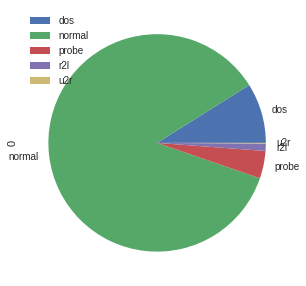

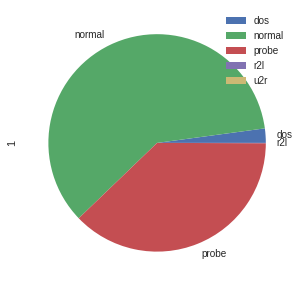

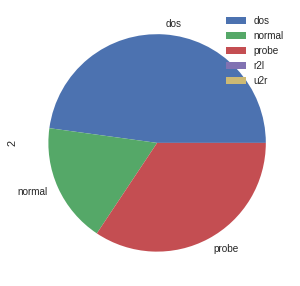

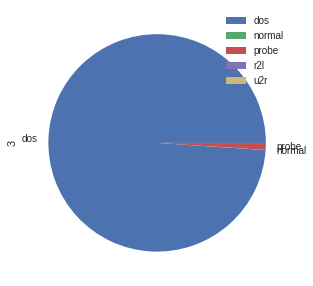

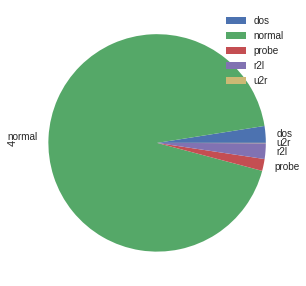

In [299]:
for i in range(0,5):
    plot = hc_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [300]:
purity_X1_hc =  purity_get(hc_confusion_df)
purity_X1_hc

0.8408672693815505

### reduced_X2 (Hierarchical Clustering)

In [301]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(reduced_X2)

array([0, 2, 0, ..., 3, 1, 3])

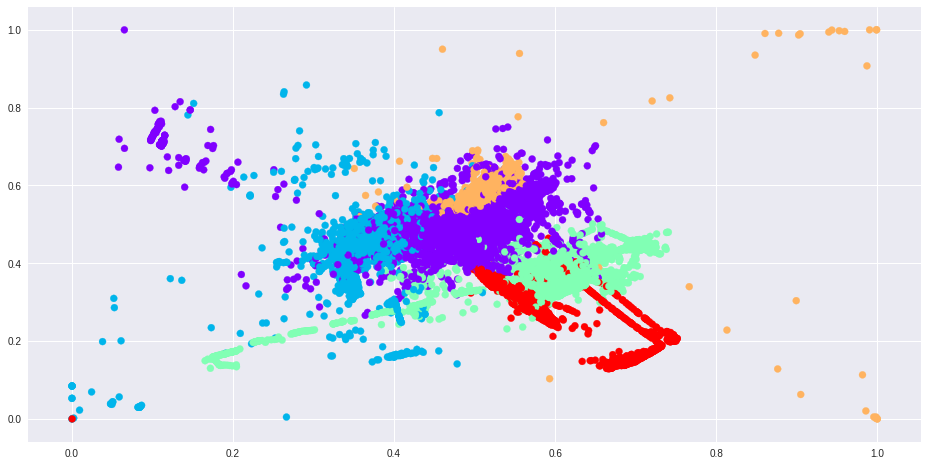

In [302]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(reduced_X2[:,0], reduced_X2[:,1], c=cluster.labels_, cmap='rainbow')

In [303]:
cluster_series = pd.Series(cluster.labels_, name='Clusters')
label_series = pd.Series(labels, name='Classes')
hc_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
hc_confusion_df = hc_confusion_df.iloc[:-1, :-1]
print(tabulate(hc_confusion_df, headers='keys', tablefmt='psql'))

+-----------+-------+------+------+------+------+
| Classes   |     0 |    1 |    2 |    3 |    4 |
|-----------+-------+------+------+------+------|
| dos       |   478 |   43 | 1369 | 6758 |  466 |
| normal    | 10100 | 1330 |  563 |   39 | 1332 |
| probe     |   530 |  809 |  972 |    1 |    1 |
| r2l       |   176 |   19 |    0 |    2 |    0 |
| u2r       |    10 |    0 |    0 |    0 |    0 |
+-----------+-------+------+------+------+------+


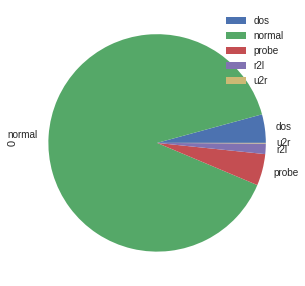

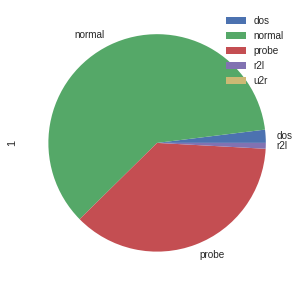

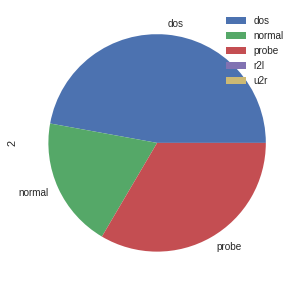

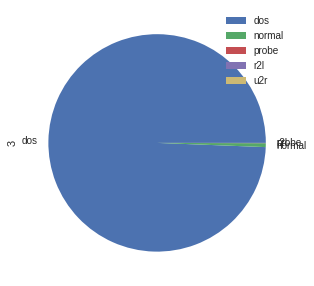

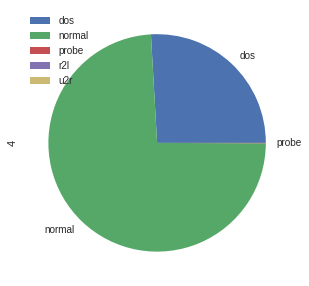

In [304]:
for i in range(0,5):
    plot = hc_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [305]:
purity_X2_hc =  purity_get(hc_confusion_df)
purity_X2_hc

0.8356268501480119

### reduced_X3 (Hierarchical Clustering)

In [306]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(reduced_X3)

array([0, 2, 0, ..., 2, 3, 4])

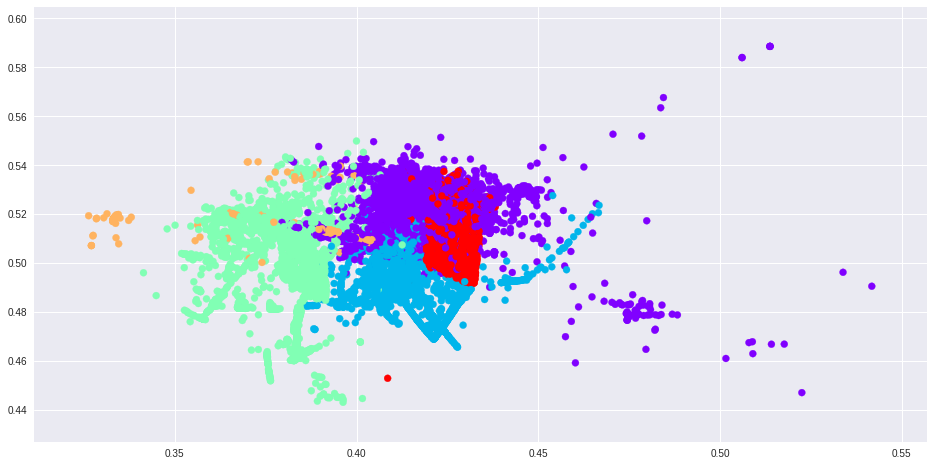

In [307]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(reduced_X3[:,0], reduced_X3[:,1], c=cluster.labels_, cmap='rainbow')

In [308]:
cluster_series = pd.Series(cluster.labels_, name='Clusters')
label_series = pd.Series(labels, name='Classes')
hc_confusion_df = pd.crosstab(label_series, cluster_series, margins=True)
hc_confusion_df = hc_confusion_df.iloc[:-1, :-1]
print(tabulate(hc_confusion_df, headers='keys', tablefmt='psql'))

+-----------+-------+-----+------+-----+------+
| Classes   |     0 |   1 |    2 |   3 |    4 |
|-----------+-------+-----+------+-----+------|
| dos       |   380 | 574 | 1368 |   0 | 6792 |
| normal    | 12111 | 628 |  570 |  33 |   22 |
| probe     |   133 | 539 |  828 | 809 |    4 |
| r2l       |   195 |   1 |    1 |   0 |    0 |
| u2r       |     6 |   4 |    0 |   0 |    0 |
+-----------+-------+-----+------+-----+------+


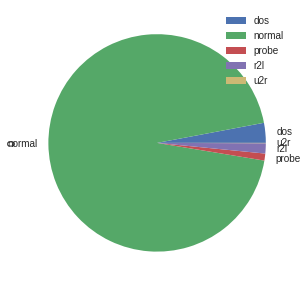

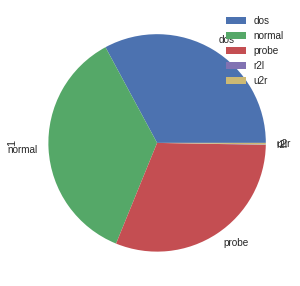

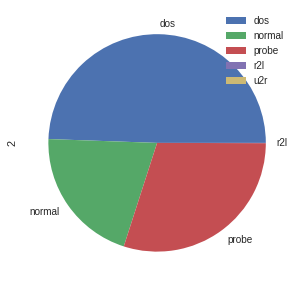

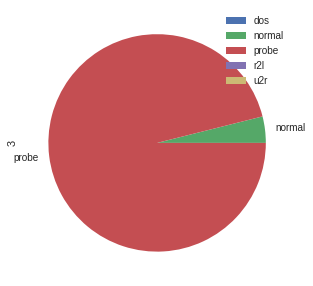

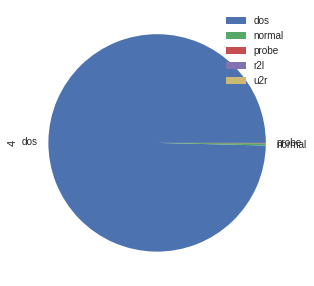

In [309]:
for i in range(0,5):
    plot = hc_confusion_df.plot.pie(y= i, figsize=(5, 5))

In [310]:
purity_X3_hc =  purity_get(hc_confusion_df)
purity_X3_hc

0.8683894711576926

## Part-5: Create a pie chart comparing purity of different clustering methods you have tried for all classes for the different autoencoders.

In [0]:
def draw_purity_pie_chart(purity1, purity2, purity3):
    labels_Part_a = 'KMeans', 'GMM', 'Hierarchical'
    sizes = [purity1,purity2,purity3]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels_Part_a, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

### reduced_X1 data

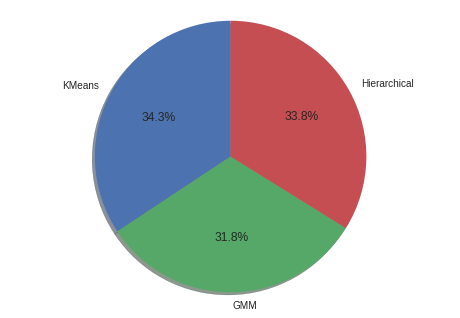

In [313]:
draw_purity_pie_chart(purity_X1_kmeans, purity_X1_gmm, purity_X1_hc)

### reduced_X2

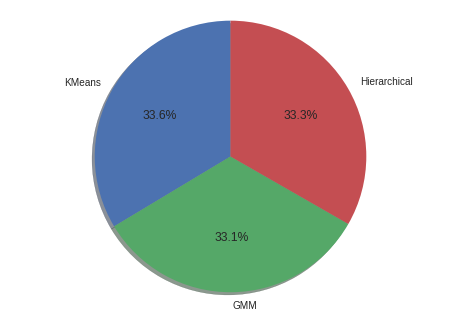

In [316]:
draw_purity_pie_chart(purity_X2_kmeans, purity_X2_gmm, purity_X2_hc)

### reduced_X3

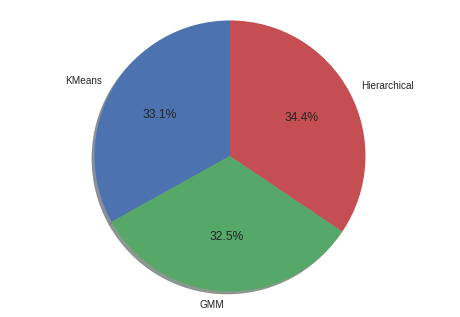

In [317]:
draw_purity_pie_chart(purity_X3_kmeans, purity_X3_gmm, purity_X3_hc)